# The all-particle spectrum of cosmic rays

In [1]:
import numpy
import matplotlib
from matplotlib import pyplot

#### We will use a library a former colleague wrote some years ago to collect cosmic rays data from a database.
It uses sqlite3, a python package that allows accessing a database using the SQL query language.

In [2]:
import crdata

Now just some plotting stuff that you can define at beginning of your notebook.

In [3]:
color = matplotlib.cm.tab20c(
    matplotlib.colors.Normalize(vmin=0, vmax=14)(range(14))
)
marker = "o"

You can also have a file.mplstyle with all your favorite settings stored somewhere and simply use it in all your notebooks :)

In [4]:
# pyplot.style.use('my_plots.mplstyle')

#### Let's see what can we do with our crdata library

In [5]:
db = crdata.CRDataBase()

In [6]:
db.experiments

['Auger',
 'GAMMA',
 'TA SD',
 'HAWC',
 'IceTop-73',
 'KASCADE-Grande',
 'KASCADE (QGSJet-I)',
 'Tibet-III (QGSJet-01C, HD)',
 'HiRes-I',
 'HiRes-II',
 'HiRes/MIA',
 'CREAM-I/III (protons)',
 'CREAM-I/III (helium)']

I'll select only some experiments per energy range, just to have a cleaner plot.

In [7]:
experiments = [
    "AMS02", "CREAM-I/III (protons)", "HAWC",
    "Tibet-III (QGSJet-01c, HD)", "IceTop-73", "GAMMA", "KASCADE-Grande",
    "HiRes-I", "HiRes-II", "Auger", "TA SD"
]

Let's request the data for the selected experiments.

In [8]:
data = {}

# For AMS02 data we have to request the data from an external database.
# Try to request "AMS02" data for hydrogen as function of the 
data["AMS02"] = db.from_external("AMS02", element="H", energy="R")
data["AMS02"] = data["AMS02"][~data["AMS02"]["uplim"]]

# And then also for the rest of the experiments...
for experiment in experiments[1:]:
    data[experiment] = db.request(experiment)
    data[experiment] = data[experiment][~data[experiment]["uplim"]]

And finally plot the all-particle spectrum!

In [9]:
# Since I want to do the same plot multiple times,
# I can have a simple function that makes it easier.

# We can give hint to the user about what the type of the
# arguments in our functions should .

def nice_plots(ax, spectral_index, xlim: tuple, ylim: tuple, title=""):
    
    # Let's set the axis labels
    ax.set_xlabel("E [GeV]", labelpad=10)
    if spectral_index != 0.:
        ax.set_ylabel(
            f"$E^{{{spectral_index}}}$" + 
            "$\Phi$ [GeV$^{{-1}}\,$m$^{{-2}}\,$sr$^{{-1}}\,$s$^{{-1}}$]"
        )
    else:
        ax.set_ylabel(r"$\Phi$ [GeV$^{-1}\,$m$^{-2}\,$sr$^{-1}\,$s$^{-1}$]")
        
    ax.set_title(str(title))

    # How do you show errorbars for each of the datasets in one plot?
    for i,experiment in enumerate(data.keys()):
        ax.errorbar(
            data[experiment]["energy"],
            data[experiment]["flux"]*data[experiment]["energy"]**spectral_index,
            numpy.sqrt(
                data[experiment]["stat"]**2+data[experiment]["sys"]**2
            ).T * data[experiment]["energy"]**spectral_index,
            fmt=marker, color=color[i], label=experiment, alpha=.9-(i%3)/3)
        
    ax.loglog(nonpositive="clip")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

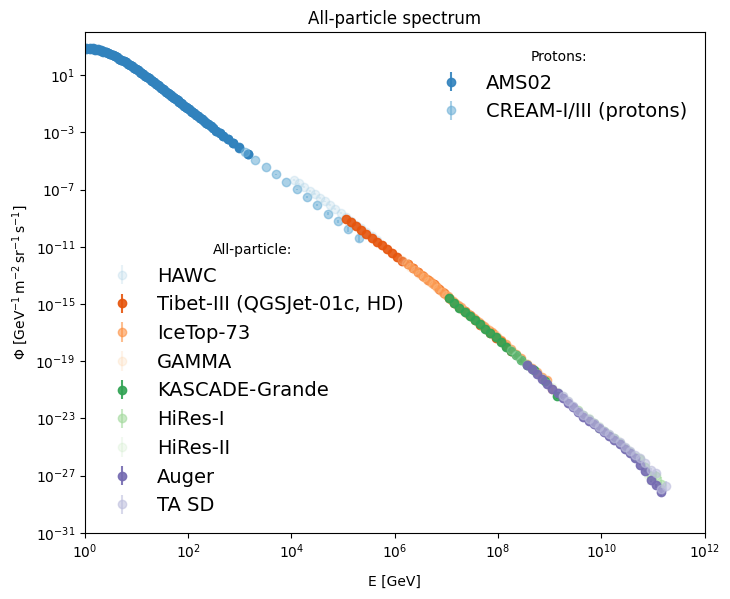

In [10]:
fig, ax = pyplot.subplots(figsize=(8,6.5))

spectral_index = 0
xlim = (1, 1e12)
ylim = (1e-31, 1e4)

# We can have our function doing a nice plot for us now :)
nice_plots(ax, spectral_index, xlim, ylim, title="All-particle spectrum")

# And add a nice legend:
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:2], labels[:2],
                   frameon=False, loc="upper right",
                   title="Protons:", fontsize=14)
ax.add_artist(legend)
legend = ax.legend(handles[2:], labels[2:],
                   frameon=False, loc="lower left",
                   title="All-particle:", fontsize=14)

pyplot.savefig(
    "/home/mwolf/all_particle_spectrum.png",
    dpi=300, bbox_inches='tight', facecolor='w')

#### Let's have a closer look to the knee and the ankle:

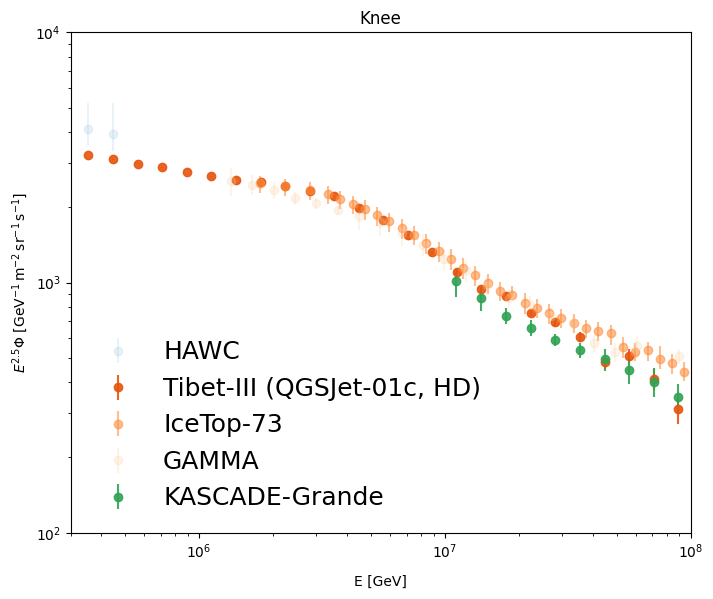

In [11]:
fig, ax = pyplot.subplots(figsize=(8,6.5))

spectral_index = 2.5
xlim = (3e5, 1e8)
ylim = (1e2, 1e4)

nice_plots(ax, spectral_index, xlim, ylim, title="Knee")

ax.legend(handles[2:-4], labels[2:-4],
          frameon=False, loc="lower left",
          fontsize=18)

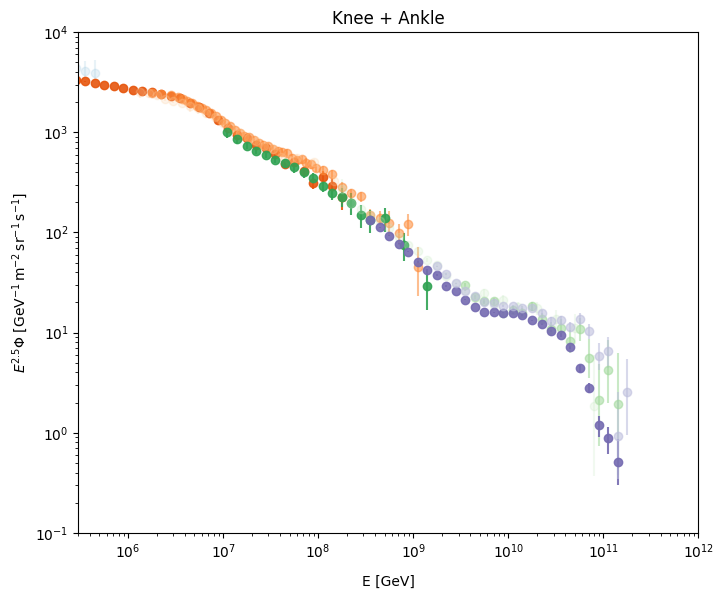

In [12]:
fig, ax = pyplot.subplots(figsize=(8,6.5))

spectral_index = 2.5
xlim = (3e5, 1e12)
ylim = (1e-1, 1e4)

nice_plots(ax, spectral_index, xlim, ylim, title='Knee + Ankle')

# ax.legend(handles[2:], labels[2:],
#           frameon=False, loc="lower left",
#           fontsize=18)

pyplot.savefig("/home/mwolf/all_particle_spectrum_features.png",
            dpi=300, bbox_inches='tight', facecolor='w')

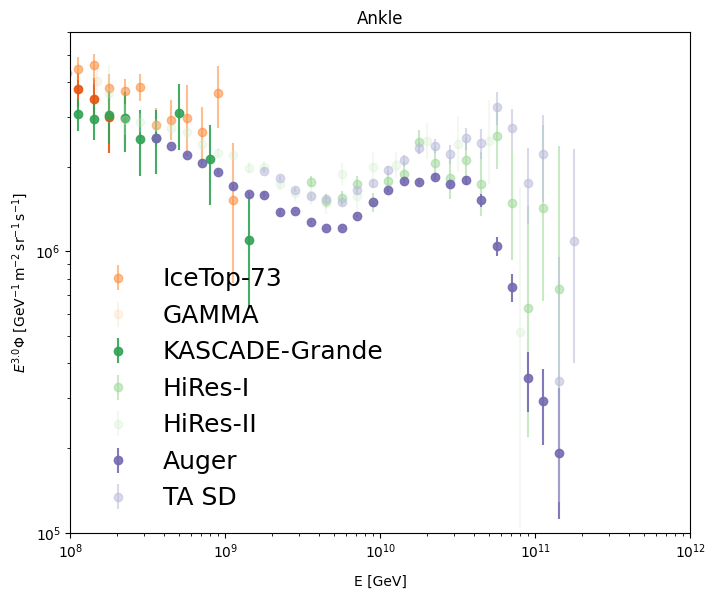

In [13]:
fig, ax = pyplot.subplots(figsize=(8,6.5))

spectral_index = 3.0
xlim = (1e8, 1e12)
ylim = (1e5, 6e6)

nice_plots(ax, spectral_index, xlim, ylim, title="Ankle")

ax.set_title("Ankle")

ax.legend(handles[4:], labels[4:],
          frameon=False, loc="lower left",
          fontsize=18)

### Let's try first to fit something simple.
We can try to take Tibet-III data, which cover the energy region around the knee, and try to fit two power laws and the knee energy.

In [14]:
from scipy.optimize import curve_fit

In [15]:
# Let's take Tibet data, which cover the knee region of the spectrum.
experiment = "Tibet-III (QGSJet-01c, HD)"
exp_energies = data[experiment]["energy"]
exp_fluxes = data[experiment]["flux"]

In [16]:
# In general linear functions are more stable than exponentials.
# We can take advantage of the log-log scale and fit straight lines
# instead of power laws.

def fit_func(E, a, b):
    y = a + b * E
    return y

In [17]:
# Function to calculate the residuals between
# the total fitted flux and the experimental data.

def residuals(y, flux):
    residuals = numpy.sum((flux - y) ** 2)
    return residuals

In [19]:
# I start initializing some empty containers for the fit results.

res = []
break_energy = []
param_below, param_above = [], []

spectral_index = 2.5

# To find the knee position I fit the 2 straight lines using 
# different energies as breaking energies.
# Then I compute the residuals between the fitted flux and
# the data for each set of fit parameters.
# Finally, I pick as the knee energy the one for which
# the sum of the residuals squared is minimal.
# This method is a very standard approach in data fitting
# problems and is known as LEAST SQUARES METHOD.

for i,ene in enumerate(numpy.log10(exp_energies[4:-4])): # Here I don't start from the very first energy in the range because 
    
    # Let's start with the low energy part (below the knee).
    popt_low, pcov = curve_fit(
        fit_func,
        # We need to select the correct energy range where to fit.
        numpy.log10(exp_energies[numpy.log10(exp_energies)<ene]),
        numpy.log10(
            exp_fluxes[numpy.log10(exp_energies)<ene]
        ) + spectral_index * numpy.log10(
            exp_energies[numpy.log10(exp_energies)<ene]
        ),
        sigma=numpy.sum(numpy.sqrt(
            data[experiment]["stat"][numpy.log10(exp_energies)<ene]**2+data[experiment]["sys"][numpy.log10(exp_energies)<ene]**2
        ).T, axis=0) + spectral_index * numpy.log10(
            exp_energies[numpy.log10(exp_energies)<ene])
    )
    
    # Then another straight line for the spectrum above the knee.
    popt_high, pcov = curve_fit(
        fit_func,
        numpy.log10(exp_energies[numpy.log10(exp_energies)>=ene]),
        numpy.log10(
            exp_fluxes[numpy.log10(exp_energies)>=ene]
        ) + spectral_index * numpy.log10(
            exp_energies[numpy.log10(exp_energies)>=ene]
        ),
        sigma=numpy.sum(numpy.sqrt(
            data[experiment]["stat"][numpy.log10(exp_energies)>=ene]**2+data[experiment]["sys"][numpy.log10(exp_energies)>=ene]**2
        ).T, axis=0) + spectral_index * numpy.log10(
            exp_energies[numpy.log10(exp_energies)>=ene])
    )
    
    # Now we can use our function to compute the best fit fluxes
    # in both energy ranges. 
    flux_low = fit_func(
        numpy.log10(exp_energies[numpy.log10(exp_energies)<ene]),
        *popt_low
    )
    flux_high = fit_func(
        numpy.log10(exp_energies[numpy.log10(exp_energies)>=ene]),
        *popt_high
    )
    # And finally the total flux:
    total_flux = numpy.concatenate([flux_low, flux_high])
    
    # Let's compute the residuals and store all our results.
    res.append(residuals(
        total_flux,
        numpy.log10(exp_fluxes) + spectral_index * numpy.log10(exp_energies))
              )
    param_below.append(popt_low)
    param_above.append(popt_high)
    break_energy.append(ene)

res = numpy.asarray(res)
idx_best_fit = numpy.argmin(res)
knee_energy = break_energy[idx_best_fit]

print(
    "The energy of the knee is " +
    f"{10**(knee_energy+9):.2e} eV"
)
print(
    "The spectral index of the spectrum below the knee is " +
    f"{param_below[idx_best_fit][1]-spectral_index:.1f}"
)
print(
    "The spectral index of the spectrum above the knee is " + 
    f"{param_above[idx_best_fit][1]-spectral_index:.1f}"
)

The energy of the knee is 3.55e+15 eV
The spectral index of the spectrum below the knee is -2.7
The spectral index of the spectrum above the knee is -3.1


In [20]:
numpy.log10(exp_energies).size
ene

7.850033257689769

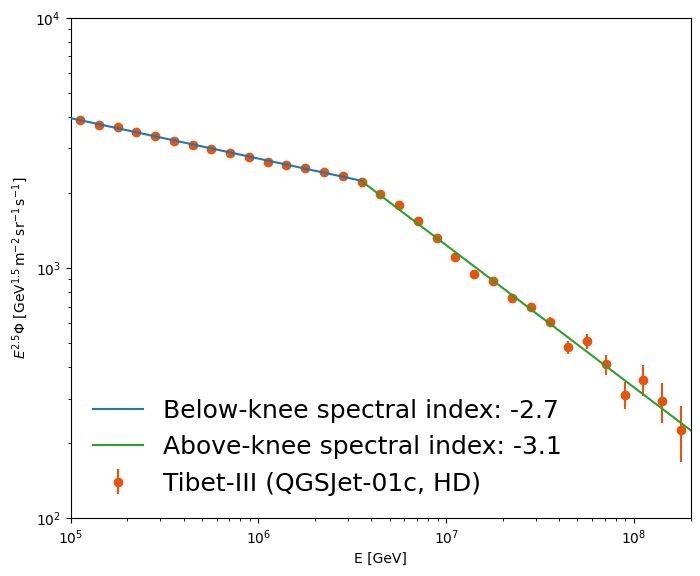

In [22]:
fig, ax = pyplot.subplots(figsize=(8,6.5))

spectral_index = 2.5
ax.set_xlabel("E [GeV]")
ax.set_ylabel(
    f"$E^{{{spectral_index}}}$" + 
    f"$\Phi$ [GeV$^{{{-1+spectral_index}}}\,$m$^{{-2}}\,$sr$^{{-1}}\,$s$^{{-1}}$]"
)

energy = numpy.logspace(4., 9., 1001)

ax.plot(
    energy[energy<10**knee_energy],
    10**fit_func(
        numpy.log10(energy[energy<10**knee_energy]), *param_below[idx_best_fit]
    ),
    "-", color="tab:blue", zorder=3,
    label=f"Below-knee spectral index: {param_below[idx_best_fit][1]-spectral_index:.1f}"
)
ax.plot(
    energy[energy>=10**knee_energy],
    10**fit_func(
        numpy.log10(energy[energy>=10**knee_energy]),*param_above[idx_best_fit]
    ), 
    "-", color="tab:green", zorder=3,
    label=f"Above-knee spectral index: {param_above[idx_best_fit][1]-spectral_index:.1f}"
)

experiment = "Tibet-III (QGSJet-01c, HD)"
ax.errorbar(
    data[experiment]["energy"],
    data[experiment]["flux"]*data[experiment]["energy"]**spectral_index,
    numpy.sqrt(
        data[experiment]["stat"]**2+data[experiment]["sys"]**2
    ).T * data[experiment]["energy"]**spectral_index,
    fmt=marker, color=color[3], label=experiment, alpha=1)

ax.loglog(nonpositive="clip")
ax.set_xlim(1e5, 2e8)
ax.set_ylim(1e2, 1e4)

ax.legend(frameon=False, loc="lower left", fontsize=18)

### Prof. Resconi told you about the H4a model last time. Let's see how well it reproduces the data.

In [23]:
class Flux(object):
    r"""Flux component of H4a model
    
    Flux parametrization:
    
    .. math::
    
        \Phi = p_{1} \times E^{-p_{2} - 1} \times \exp(-E / p_{3} / R_{c})
        
    Attributes
    ----------
    params : tuple(float)
        The three parameters :math:`p_{1}, p_{2}, p_{3}`
    cutoff : float
        Rigidity cutoff :math:`R_{c}` 
    
    """
    def __init__(self, params, cutoff):
        self.params = params
        self.cutoff = cutoff
    
    # __call__ is a built-in method in python that allows to use the
    # instance as if it was a function
    #
    def __call__(self, energy):
        r"""Calculate the differential flux at the given `energy`.
        
        Parameters
        ----------
        energy : array_like
            Energy in GeV
            
        Returns
        -------
        array_like
            Differential flux in m^2 per GeV, s, and sr
        
        """
        flux = (
            self.params[0] *
            numpy.power(energy, -self.params[1] - 1.) *
            numpy.exp(-energy / self.params[2] / self.cutoff)
            )
            
        return flux

In [24]:
class TotalFlux(object):
    r"""H4a model
    
    Total all-particle primary cosmic-ray flux predicted by the H4a model.
    
    Attributes
    ----------
    components : list(Flux)
        Flux components; the model consists of three populations of cosmic
        rays; the first two have a five component mass composition; the
        third population consits of protons only.
    
    """
    def __init__(self, components):
        self.components = components
      
    def __call__(self, energy):
        r"""Calculate the differential flux at the given `energy`.
        
        Parameters
        ----------
        energy : array_like
            Energy in GeV
            
        Returns
        -------
        array_like
            Differential flux in m^2 per GeV, s, and sr
        
        """
        return sum(c(energy) for c in self.components)

In [25]:
components = {}

# The following values are the ones from 
# https://www.sciencedirect.com/science/article/pii/S0927650512000497?via%3Dihub

In [32]:
components["H"] = [
    Flux(params=(7860., 1.66, 1.), cutoff=4e6),
    Flux(params=(20., 1.4, 1.), cutoff=3e7),
    Flux(params=(200., 1.6, 1.), cutoff=6e10)
]
components["He"] = [
    Flux(params=(3550., 1.58, 2.), cutoff=4e6),
    Flux(params=(20., 1.4, 2.), cutoff=3e7)
]
components["CNO"] = [
    Flux(params=(2200., 1.63, 6.), cutoff=4e6),
    Flux(params=(13.4, 1.4, 6.), cutoff=3e7)
]
components["MgAlSi"] = [
    Flux(params=(1430., 1.67, 14.), cutoff=4e6),
    Flux(params=(13.4, 1.4, 14.), cutoff=3e7)
]
components["Fe"] = [
    Flux(params=(2120., 1.63, 26.), cutoff=4e6),
    Flux(params=(13.4, 1.4, 26.), cutoff=3e7)
]
h4a = TotalFlux(
    components=[c for k in components for c in components[k]])

In [33]:
# A useful way of building equally spaced sequences of numbers.
# In this case on a log scale.
energy = numpy.logspace(4., 12., 1001)

# h4a is a TotalFlux object, which has a __call__ method
# we can use now to compute the flux in our energy range.
flux = h4a(energy)

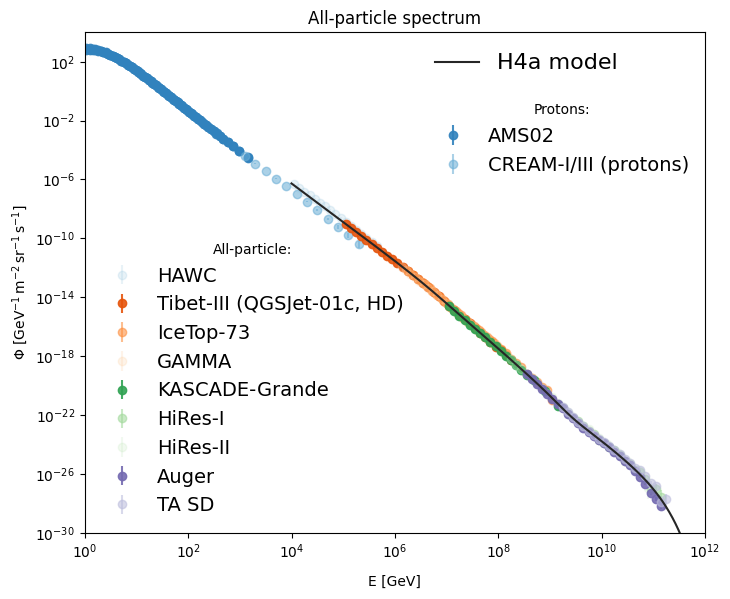

In [34]:
fig, ax = pyplot.subplots(figsize=(8,6.5))

spectral_index = 0
xlim = (1, 1e12)
ylim = (1e-30, 1e4)

ax.plot(energy, flux * energy**spectral_index, "-", color="0.15", label="H4a model", zorder=3)

nice_plots(ax, spectral_index, xlim, ylim, title="All-particle spectrum")

# A nice legend:
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:1], labels[:1],
                   frameon=False, loc=(.55,.9),
                   fontsize=16)
ax.add_artist(legend)
legend = ax.legend(handles[1:3], labels[1:3],
                   frameon=False, loc=(.55,.7),
                   title="Protons:", fontsize=14)
ax.add_artist(legend)
legend = ax.legend(handles[3:], labels[3:],
                   frameon=False, loc="lower left",
                   title="All-particle:", fontsize=14)

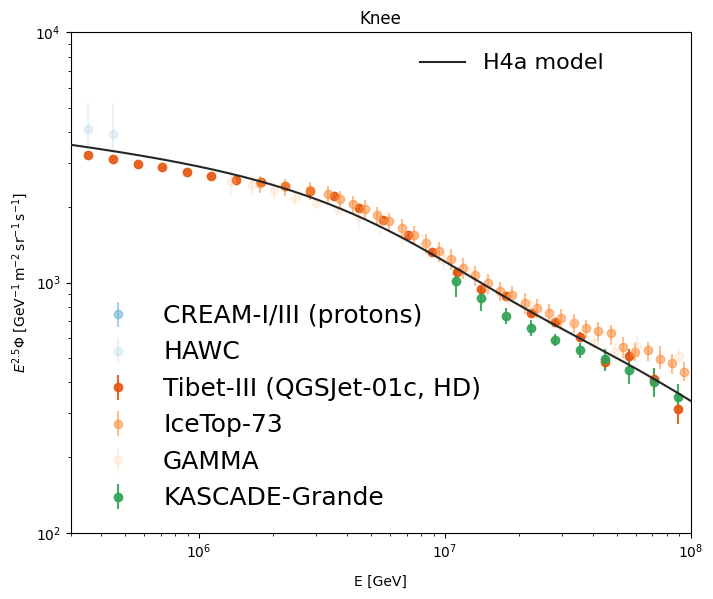

In [35]:
fig, ax = pyplot.subplots(figsize=(8,6.5))

spectral_index = 2.5
xlim = (3e5, 1e8)
ylim = (1e2, 1e4)

ax.plot(energy, flux * energy**spectral_index, "-", color="0.15", label="H4a model", zorder=3)

nice_plots(ax, spectral_index, xlim, ylim, title="Knee")

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:1], labels[:1],
                   frameon=False, loc=(.55,.9),
                   fontsize=16)
ax.add_artist(legend)

legend = ax.legend(handles[2:-4], labels[2:-4],
          frameon=False, loc="lower left",
          fontsize=18)

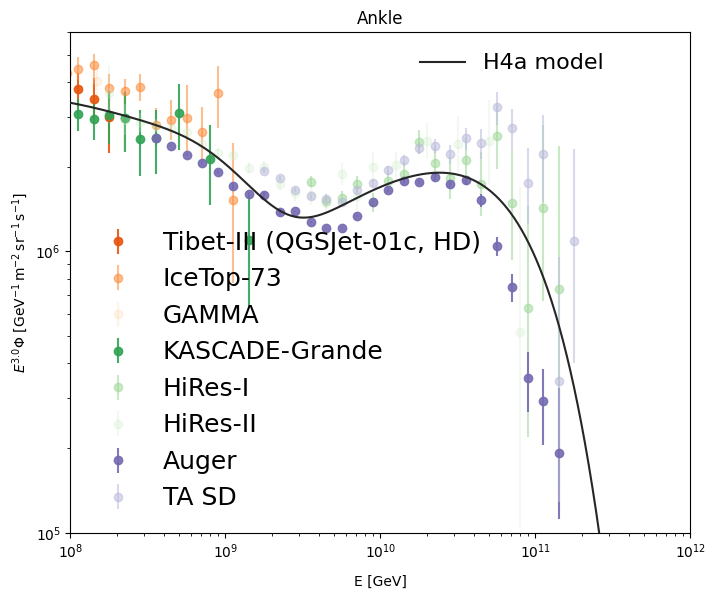

In [36]:
fig, ax = pyplot.subplots(figsize=(8,6.5))

spectral_index = 3.0
xlim = (1e8, 1e12)
ylim = (1e5, 6e6)

ax.plot(energy, flux * energy**spectral_index, "-", color="0.15", label="H4a model", zorder=3)

nice_plots(ax, spectral_index, xlim, ylim, title="Ankle")

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:1], labels[:1],
                   frameon=False, loc=(.55,.9),
                   fontsize=16)
ax.add_artist(legend)

legend = ax.legend(handles[4:], labels[4:],
          frameon=False, loc="lower left",
          fontsize=18)

### If everything was very easy for you so far you can try something sligthly more complicated.
Try to fit the function again, but this time using all the measurements you have around the knee, not just one dataset.
HINT: when looking at different datasets, you may run into more than one flux measurement for the same energy bin. But minimizers will not accept many y-values for the same x-value (because that would break the definition of "function".
you can try to combine different measurement buy taking the weighted average of different measurement.
For simplicity, assume the errors are symmetric and take the largest of the 2 values to be conservative.

In [50]:
# Let's prepare our data.

exp_energies, exp_fluxes, exp_errors_low, exp_errors_high = [], [], [], []
exp_energies = data[experiments[0]]["energy"]
exp_fluxes = data[experiments[0]]["flux"]
exp_errors_low = numpy.sqrt(
    data[experiments[0]]["stat"]**2+data[experiments[0]]["sys"]**2
).T[0]
exp_errors_high = numpy.sqrt(
    data[experiments[0]]["stat"]**2+data[experiments[0]]["sys"]**2
).T[1]
for i,experiment in enumerate(experiments[1:]):
    exp_energies = numpy.append(exp_energies, data[experiment]["energy"])
    exp_fluxes = numpy.append(exp_fluxes, data[experiment]["flux"])
    exp_errors_low = numpy.append(exp_errors_low, numpy.sqrt(
            data[experiment]["stat"]**2+data[experiment]["sys"]**2
        ).T[0]
    )
    exp_errors_high = numpy.append(exp_errors_high, numpy.sqrt(
            data[experiment]["stat"]**2+data[experiment]["sys"]**2
        ).T[0]
    )
                                
exp_fluxes = exp_fluxes[exp_energies>1e4]
exp_errors = (exp_errors_low[exp_energies>1e4], exp_errors_high[exp_energies>1e4])
exp_energies = exp_energies[exp_energies>1e4]

In [51]:
# For energies at which we have more than one measurement, we take the weighted mean:
idx_to_delete = []

for i,e in enumerate(exp_energies):
    
    if e in exp_energies[i+1:]:
        
        idxs = numpy.where(exp_energies == e)[0]
        tmp_flux = numpy.average(exp_fluxes[idxs])
        exp_fluxes[i] = tmp_flux
        idx_to_delete.append(idxs[1:])
        
idx_to_delete = numpy.concatenate(idx_to_delete)
exp_energies = exp_energies[~idx_to_delete]
exp_fluxes = exp_fluxes[~idx_to_delete]